# Object-wise Scoring in Remote Sensing

Sometimes we want to have object-wise scoring instead of IoU to have an understanding of how good we are in identifying objects (e.g., buildings, solar panels, etc). This scripts demonstrates how to evaluate predictions using this criterion.

## Get Confidence Map

In order to get the confidence map, set `save_conf=True` when calling `evaluator.evaluate()` in the given evaluate [example script](../evaluate.py). We'll just load some existing files for demonstrating purpose.

In [1]:
import sys
sys.path.append(r'/home/lab/Documents/bohao/code/mrs')

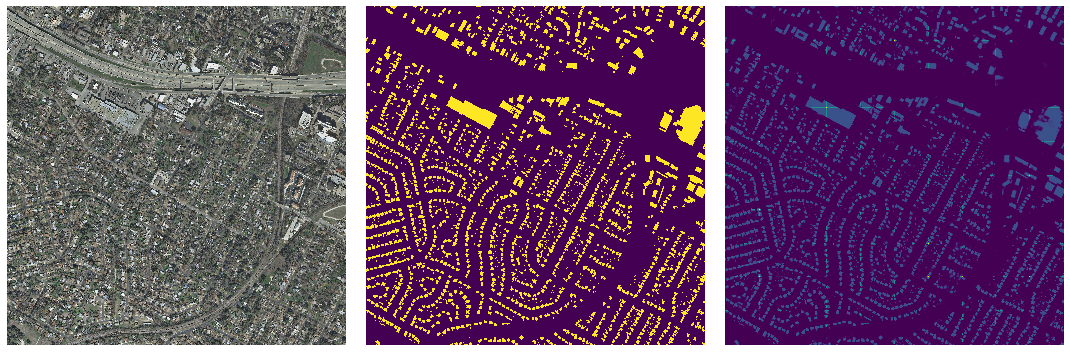

In [2]:
%matplotlib inline
from mrs_utils import misc_utils, vis_utils

rgb_file = r'/media/ei-edl01/data/remote_sensing_data/inria/images/austin1.tif'
lbl_file = r'/media/ei-edl01/data/remote_sensing_data/inria/gt/austin1.tif'
conf_file = r'/hdd/Results/mrs/inria/ecresnet50_dcunet_dsinria_lre1e-04_lrd1e-04_ep50_bs7_ds50_dr0p1/austin1.npy'
rgb = misc_utils.load_file(rgb_file)
lbl_img, conf_img = misc_utils.load_file(lbl_file)/255, misc_utils.load_file(conf_file)
vis_utils.compare_figures([rgb, lbl_img, conf_img], (1, 3), fig_size=(15, 5))

## Create ObjectScorer Class

The `ObjectScorer` class defined in [eval_utils.py](../mrs_utils/eval_utils.py) is desined specifically for object-wise evaluation related tasks. The code below creates a scoring object that binarize the input ground truth or conf map with a threshold of 0.5. 

In [3]:
from mrs_utils import eval_utils
osc = eval_utils.ObjectScorer(min_th=0.5, link_r=10, eps=2)

## Group Objects

Sometimes an 'object' are not just connected pixels, e.g., a building and it's garage in a separate place form one single 'object'. To group them together automatically, we link connected components with in certrain range (20 pixels) in this example as one 'object'.

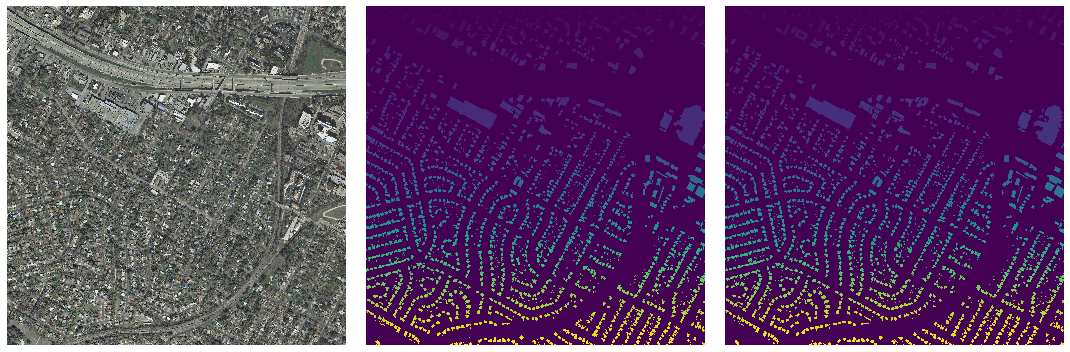

In [4]:
lbl_groups = osc.get_object_groups(lbl_img)
conf_groups = osc.get_object_groups(conf_img)
lbl_group_img = eval_utils.display_group(lbl_groups, lbl_img.shape[:2], need_return=True)
conf_group_img = eval_utils.display_group(conf_groups, conf_img.shape[:2], need_return=True)
vis_utils.compare_figures([rgb, lbl_group_img, conf_group_img], (1, 3), fig_size=(15, 5))

## Score the Conf Map

`score()` is a helper function for creating scorer function, group objects and link the prediction to ground truth. The preds are categorized under the following criterions:
1. TP -> a pred and label has object-wise IoU above a threshold
2. FP -> a pred has no label with an object-wise IoU above a threshold
3. FN -> a label has no pred with an object-wise IoU above a threshold
The example below shows how to score the prediction with an IoU threshold of 0.5

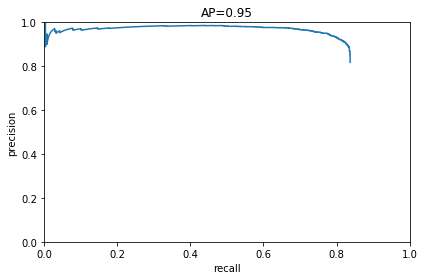

In [5]:
conf_list, true_list = eval_utils.score(conf_img, lbl_img, min_th=0.5, link_r=10, iou_th=0.5)
ap, p, r, _ = eval_utils.get_precision_recall(conf_list, true_list)
import matplotlib.pyplot as plt
plt.plot(r[1:], p[1:])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('AP={:.2f}'.format(ap))
plt.tight_layout()
plt.show()